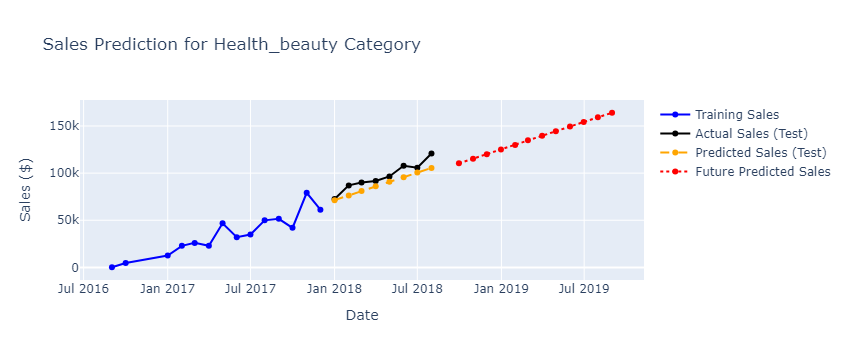

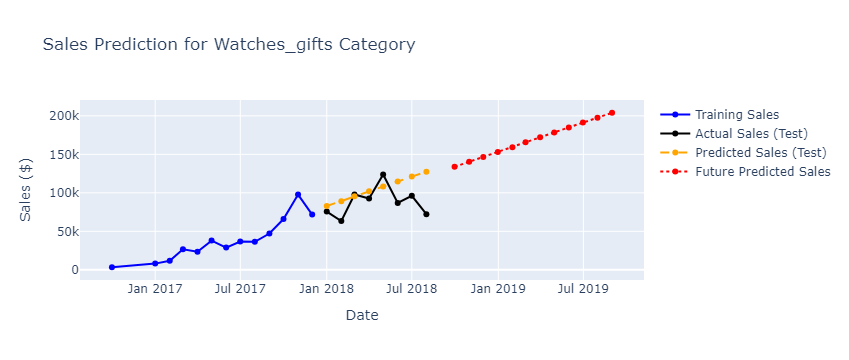

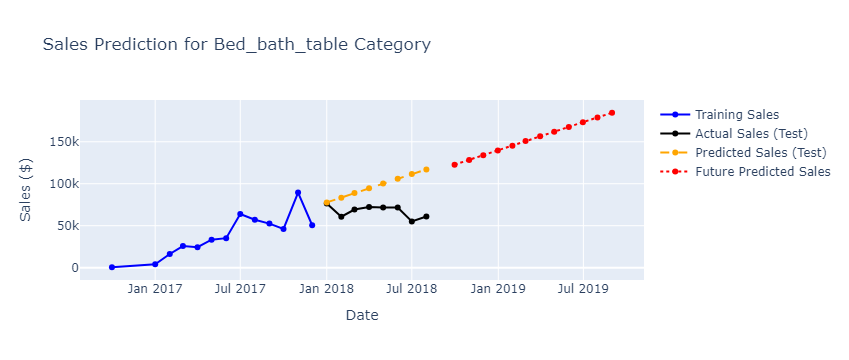

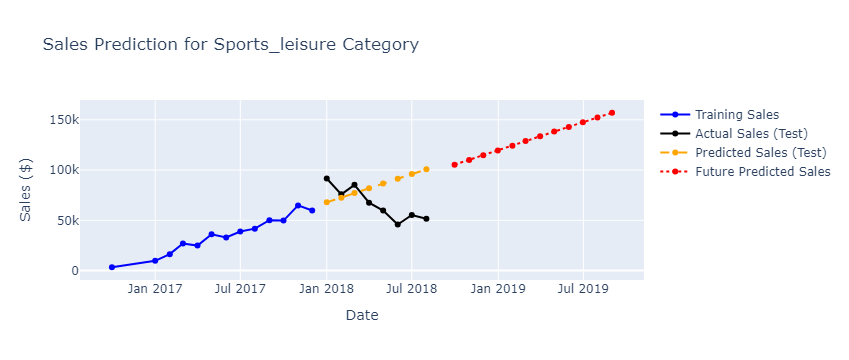

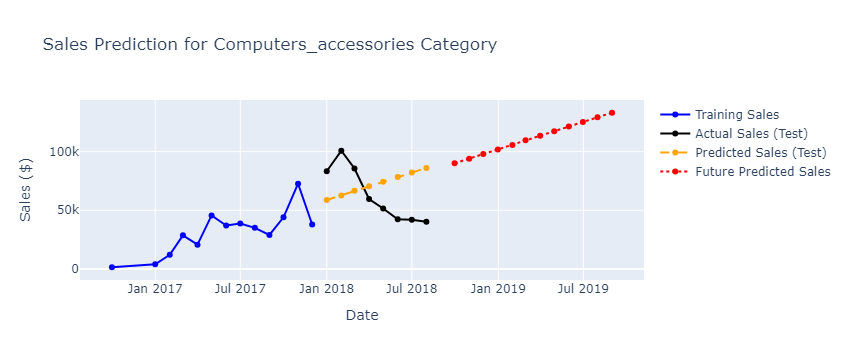

Evaluation Metrics:
                                MAE           MSE          RMSE   R² Score
health_beauty           8100.579069  8.374210e+07   9151.071045   0.564882
watches_gifts          20995.015385  6.859277e+08  26190.220552  -1.217958
bed_bath_table         30156.647500  1.213864e+09  34840.546892 -24.450965
sports_leisure         26484.903420  9.656370e+08  31074.699610  -3.078123
computers_accessories  29718.106360  1.011599e+09  31805.636357  -1.081288

The category with the highest predicted sales is: watches_gifts with predicted sales of $841170.75
Future predicted sales for health_beauty for the next 12 months: 1339487.16
Future predicted sales for watches_gifts for the next 12 months: 1339487.16
Future predicted sales for bed_bath_table for the next 12 months: 1339487.16
Future predicted sales for sports_leisure for the next 12 months: 1339487.16
Future predicted sales for computers_accessories for the next 12 months: 1339487.16


In [15]:
import pandas as pd
import plotly.graph_objs as go
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Load the cleaned dataset
full_data = pd.read_csv('cleaned_full_data.csv')

# Step 1: Calculate total sales for each product category
total_sales_by_category = (
    full_data.groupby('product_category_name_english')['price']
    .sum()
    .reset_index()
)

# Step 2: Identify the top 5 categories by total sales
top_categories = total_sales_by_category.nlargest(5, 'price')['product_category_name_english'].tolist()

# Prepare a summary dictionary for the results
results_summary = {}
predicted_sales_summary = {}

# Number of future months to predict
future_months = 12  # For example, predicting for the next 12 months

# Step 3: Time Series Analysis for Each Top Category
for category_name in top_categories:
    # Filter data for the specific category
    category_data = full_data[full_data['product_category_name_english'] == category_name]

    # Group by year and month, summing up the sales
    category_monthly_sales = category_data.groupby(['order_year', 'order_month'])['price'].sum().reset_index()

    # Create a new Date column for easy time-based indexing
    category_monthly_sales['date'] = pd.to_datetime(
        category_monthly_sales['order_year'].astype(str) + '-' + 
        category_monthly_sales['order_month'].astype(str).str.zfill(2) + '-01'
    )

    # Sort values by date
    category_monthly_sales = category_monthly_sales.sort_values(by='date').reset_index(drop=True)

    # Split data: 2016-2017 for training, 2018 for testing
    train_data = category_monthly_sales[category_monthly_sales['date'] < '2018-01-01'].copy()
    test_data = category_monthly_sales[category_monthly_sales['date'] >= '2018-01-01'].copy()

    # Set up features and target variable
    train_data.loc[:, 'time_index'] = range(len(train_data))
    test_data.loc[:, 'time_index'] = range(len(train_data), len(train_data) + len(test_data))
    X_train = train_data[['time_index']]
    y_train = train_data['price']
    
    # Create and train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions for the test set
    y_pred_test = model.predict(test_data[['time_index']])

    # Calculate evaluation metrics
    mae = mean_absolute_error(test_data['price'], y_pred_test)
    mse = mean_squared_error(test_data['price'], y_pred_test)
    rmse = np.sqrt(mse)
    r2 = r2_score(test_data['price'], y_pred_test)

    # Store the results in the summary dictionary
    results_summary[category_name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R² Score': r2
    }

    # Summarize predicted sales for future analysis
    predicted_sales_summary[category_name] = {
        'Predicted Sales': y_pred_test.sum()  # Sum of predicted sales for the testing period
    }

    # Future Predictions
    last_index = len(category_monthly_sales)  # Last index in the training data
    future_time_indices = pd.DataFrame(np.arange(last_index, last_index + future_months), columns=['time_index'])
    
    # Make future predictions
    future_predictions = model.predict(future_time_indices)

    # Prepare future dates for the predicted values
    last_date = category_monthly_sales['date'].max()
    future_dates = pd.date_range(start=last_date, periods=future_months + 1, freq='ME')[1:]

    # Plotting with Plotly
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_data['date'], y=y_train, mode='lines+markers', name='Training Sales', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=test_data['date'], y=test_data['price'], mode='lines+markers', name='Actual Sales (Test)', line=dict(color='black')))
    fig.add_trace(go.Scatter(x=test_data['date'], y=y_pred_test, mode='lines+markers', name='Predicted Sales (Test)', line=dict(dash='dash', color='orange')))
    fig.add_trace(go.Scatter(x=future_dates, y=future_predictions, mode='lines+markers', name='Future Predicted Sales', line=dict(dash='dot', color='red')))
    fig.update_layout(title=f'Sales Prediction for {category_name.capitalize()} Category', xaxis_title='Date', yaxis_title='Sales ($)', hovermode="x unified")
    fig.show()

# Convert results summary to DataFrame for better visualization
results_df = pd.DataFrame(results_summary).T
predicted_sales_df = pd.DataFrame(predicted_sales_summary).T

# Display the results summary
print("Evaluation Metrics:")
print(results_df)

# Identify and display the category with the highest predicted sales
highest_sales_category = predicted_sales_df['Predicted Sales'].idxmax()
highest_sales_value = predicted_sales_df['Predicted Sales'].max()

print(f"\nThe category with the highest predicted sales is: {highest_sales_category} "
      f"with predicted sales of ${highest_sales_value:.2f}")

# Display future predictions for all top categories
for category in top_categories:
    print(f"Future predicted sales for {category} for the next {future_months} months: {future_predictions.sum():.2f}")
